# MOLE DETECTION

### Data Analyses

#### Import Necessary Libraries

In [36]:
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob
import itertools
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

#### Define default variables

In [37]:
DATA_DIR = os.path.join('.', 'data')
IMAGE_DIR = os.path.join('.', 'data\\HAM10000_images\\')


lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
labels = {
    0: 'Melanocytic nevi (nv)',
    1: 'Melanoma (mel)',
    2: 'Benign keratosis-like lesions (bkl)',
    3: 'Basal cell carcinoma (bcc)',
    4: 'Actinic keratoses (akiec)',
    5: 'Vascular lesions (vasc)',
    6: 'Dermatofibroma (df)'
}
int_label_mapping = dict((value, key) for key, value in label_mapping.items())

#### Import the data 

In [38]:
data = pd.read_csv(os.path.join(DATA_DIR,'HAM10000_metadata.csv'))
data.head(5)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [39]:
data.dtypes

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
dtype: object

In [40]:
data.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization
count,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,male,back
freq,6,1,6705,5340,5406,2192


In [41]:
data.isnull().value_counts()

lesion_id  image_id  dx     dx_type  age    sex    localization
False      False     False  False    False  False  False           9958
                                     True   False  False             57
dtype: int64

In [42]:
# We wont use age but in any case handle  null values 
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
data['age'] = data['age'].astype('int32')

In [43]:
# Adding cell_type and path of images columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = IMAGE_DIR + data['image_id'] + ".JPG"

In [44]:
# Adding image pixel data to dataframe
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [45]:
# Cinverting labels to numbers
data['label'] = data['dx'].map(int_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [46]:
data.head(5)

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
0,5007,HAM_0006322,ISIC_0030309,nv,follow_up,55,male,foot,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0030309.JPG,"[[[237, 159, 171], [238, 158, 173], [241, 161,...",0
1,4478,HAM_0003084,ISIC_0026191,nv,follow_up,45,female,upper extremity,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0026191.JPG,"[[[219, 112, 131], [223, 119, 136], [224, 121,...",0
2,4477,HAM_0002093,ISIC_0027032,nv,follow_up,45,female,back,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0027032.JPG,"[[[234, 134, 155], [238, 140, 164], [234, 130,...",0
3,4476,HAM_0003701,ISIC_0027191,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0027191.JPG,"[[[214, 121, 154], [216, 124, 159], [218, 124,...",0
4,4475,HAM_0003806,ISIC_0028667,nv,follow_up,45,female,lower extremity,Melanocytic nevi (nv),.\data\HAM10000_images\ISIC_0028667.JPG,"[[[234, 146, 167], [236, 149, 171], [233, 149,...",0


<AxesSubplot:>

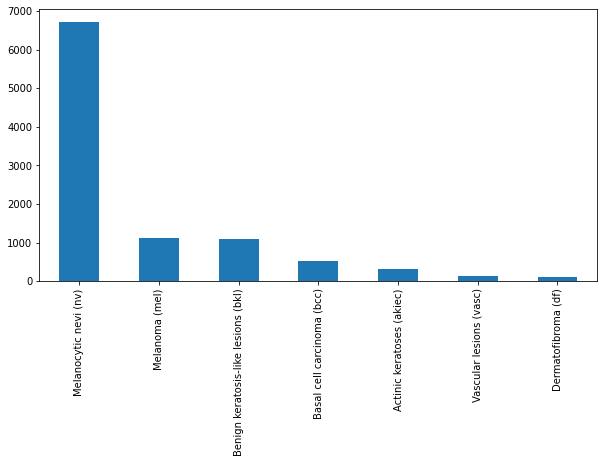

In [78]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

### Increase sample size of some groups

In [51]:
# make the same size samples 
data['label'].value_counts()

0    6705
1    1113
2    1099
3     514
4     327
5     142
6     115
Name: label, dtype: int64

### Color channel analysis

How do the normalized color samples vary across different types of skin diseases?



In [86]:
rgb_info_df = data.apply(lambda x: pd.Series({'{}_mean'.format(k): v for k, v in 
                                  zip(['Red', 'Green', 'Blue'], 
                                      np.mean(x['image_pixel'], (0, 1)))}),1)
gray_col_vec = rgb_info_df.apply(lambda x: np.mean(x), 1)
for c_col in rgb_info_df.columns:
    rgb_info_df[c_col] = rgb_info_df[c_col]/gray_col_vec
rgb_info_df['Gray_mean'] = gray_col_vec
rgb_info_df.head(10)

,Red_mean,Green_mean,Blue_mean,Gray_mean
0,1.312212,0.829177,0.858611,173.855442
1,1.350761,0.780269,0.868969,168.175170
2,1.423875,0.750906,0.825219,155.642007
3,1.311201,0.753867,0.934932,163.263605
4,1.400708,0.770060,0.829232,149.920493
5,1.337023,0.693436,0.969542,152.041667
6,1.299023,0.793066,0.907911,182.799320
7,1.292338,0.820366,0.887296,188.173469
8,1.289555,0.816879,0.893567,169.850765
9,1.307410,0.798857,0.893733,149.684524


In [83]:
for c_col in rgb_info_df.columns:
    data[c_col] = rgb_info_df[c_col].values

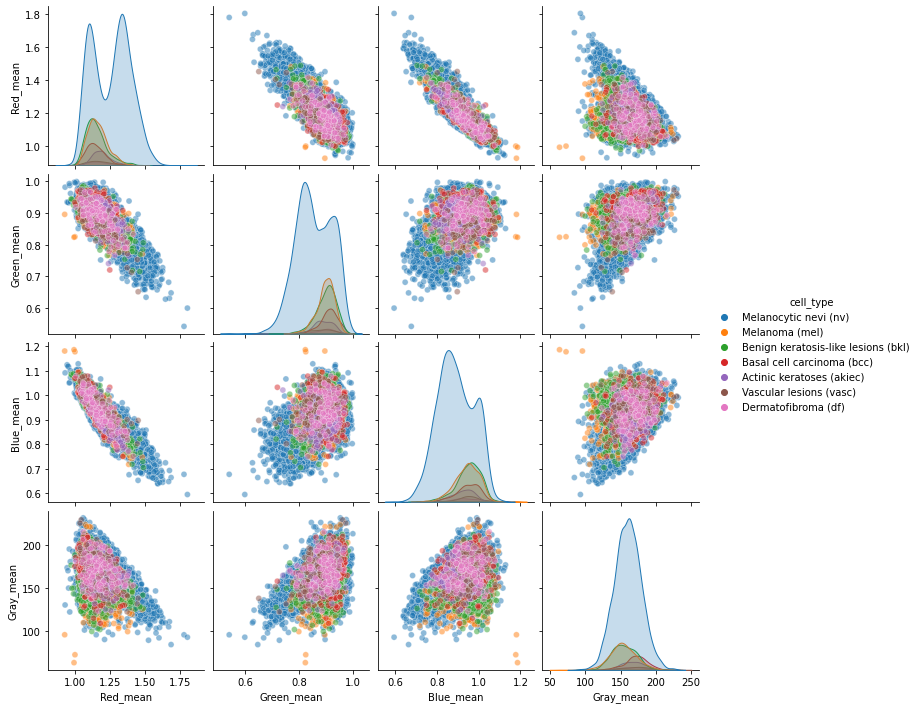

In [84]:
import seaborn as sns
sns.pairplot(data[['Red_mean', 'Green_mean', 'Blue_mean', 'Gray_mean', 'cell_type']], 
             hue='cell_type', plot_kws = {'alpha': 0.5})


Some types has a little samples, Create extra images for image generator

In [55]:
# 0	6705    1            20K			
# 1	1113	8	8904	11130
# 2	1099	8	8792	10990
# 3	514	    22	11308	12336
# 4	327	    34	11118	11772
# 5	142	    90	12780	13064
# 6	115	    104	11960	12190


_label = 0
groups = [data]
for i in [1,8,8,22,34,90,104]:
    index = data[data['label'] == _label].index.values
    df_l = data.iloc[int(min(index)):int(max(index)+1)]
    df_l = df_l.append([df_l]*i, ignore_index = True)
    groups.append(df_l)
    _label+=1

C:\Users\bakig\AppData\Local\Temp\ipykernel_16808\2627397488.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_l = df_l.append([df_l]*i, ignore_index = True)


In [56]:
final_data = pd.concat(groups)

In [85]:
final_data['label'].value_counts()

0    20115
5    13064
3    12336
6    12190
4    11772
1    11130
2    10990
Name: label, dtype: int64

In [ ]:
final_data.head(5)

Save both original and augemented data to csv for future use

In [ ]:
data.to_csv("dataall.csv")
final_data.to_csv("final_aug.csv")

In [58]:
# ORIGINAL
# Convert image pixel columnm into numpy array
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [59]:
# AUGMENTED DATA
# Convert image pixel columnm into numpy array
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(91597, 28, 28, 3)
(91597, 1)


In [60]:
def train_test(X, Y):
    # train test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
    
    # train and test (found the numbers for parameters from some other repos)
    train_datagenerate = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagenerate.fit(X_train)
    test_datagenerate = ImageDataGenerator(rescale = 1./255)
    test_datagenerate.fit(X_test)
    return X_train, X_test, Y_train, Y_test

In [61]:
def create_model():
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    return model

In [62]:
def train_model(model, X_tr, Y_tr, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1,mode='auto')
                               
    
    learning_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')
    
    history = model.fit(X_tr, Y_tr, validation_split=0.2, batch_size = 64, epochs = EPOCHS,callbacks = [learning_rate, early_stop])
    return history

In [63]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    cm=confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm,label_mapping,"44")
    print(cm)

    plt.show() 

In [64]:
def plot_confusion_matrix(cm, classes, name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

   
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('_confusion_matrix.png', dpi=300)

In [65]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = train_test(X_orig, Y_orig)
#Augemented dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = train_test(X_aug, Y_aug)

In [66]:
print(X_train_orig.shape)
print(X_train_aug.shape)

(8012, 28, 28, 3)
(73277, 28, 28, 3)


In [67]:
model =create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 64)        

In [68]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

Epoch 1/50
916/916 [==============================] - 12s 13ms/step - loss: 1.1473 - accuracy: 0.5824 - val_loss: 0.6928 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 2/50
916/916 [==============================] - 11s 12ms/step - loss: 0.4973 - accuracy: 0.8112 - val_loss: 0.3800 - val_accuracy: 0.8536 - lr: 0.0010
Epoch 3/50
916/916 [==============================] - 11s 12ms/step - loss: 0.3188 - accuracy: 0.8795 - val_loss: 0.2888 - val_accuracy: 0.8779 - lr: 0.0010
Epoch 4/50
916/916 [==============================] - 11s 12ms/step - loss: 0.2274 - accuracy: 0.9142 - val_loss: 0.2448 - val_accuracy: 0.9015 - lr: 0.0010
Epoch 5/50
916/916 [==============================] - 11s 12ms/step - loss: 0.1818 - accuracy: 0.9339 - val_loss: 0.1815 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 6/50
916/916 [==============================] - 11s 12ms/step - loss: 0.1390 - accuracy: 0.9499 - val_loss: 0.2089 - val_accuracy: 0.9222 - lr: 0.0010
Epoch 7/50
916/916 [==============================] - 11s 

##### Loss and accuracy curves for training and test sets.

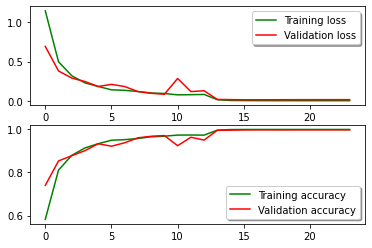

In [90]:
g, ax = plt.subplots(2,1)
ax[0].plot(model2_history.history['loss'], color='g', label="Training loss")
ax[0].plot(model2_history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(model2_history.history['accuracy'], color='g', label="Training accuracy")
ax[1].plot(model2_history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Saving the model for deployment 

In [69]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

### Test Original and Augumented datasets

Test Accuracy: 99.800%
              precision    recall  f1-score   support

          nv       1.00      1.00      1.00      1315
         mel       0.99      1.00      1.00       229
         bkl       1.00      1.00      1.00       250
         bcc       1.00      1.00      1.00       103
       akiec       1.00      1.00      1.00        61
        vasc       1.00      1.00      1.00        22
          df       0.96      1.00      0.98        23

    accuracy                           1.00      2003
   macro avg       0.99      1.00      1.00      2003
weighted avg       1.00      1.00      1.00      2003

[[1311    2    1    0    0    0    1]
 [   0  229    0    0    0    0    0]
 [   0    0  250    0    0    0    0]
 [   0    0    0  103    0    0    0]
 [   0    0    0    0   61    0    0]
 [   0    0    0    0    0   22    0]
 [   0    0    0    0    0    0   23]]


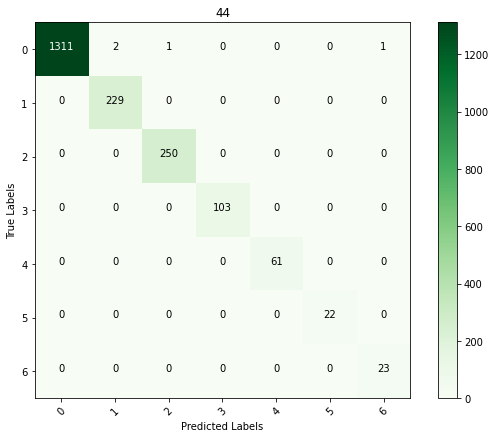

In [70]:
test_model(model, X_test_orig, Y_test_orig)

Test Accuracy: 99.825%
              precision    recall  f1-score   support

          nv       1.00      0.99      1.00      3979
         mel       0.99      1.00      1.00      2239
         bkl       0.99      1.00      1.00      2154
         bcc       1.00      1.00      1.00      2487
       akiec       1.00      1.00      1.00      2445
        vasc       1.00      1.00      1.00      2569
          df       1.00      1.00      1.00      2447

    accuracy                           1.00     18320
   macro avg       1.00      1.00      1.00     18320
weighted avg       1.00      1.00      1.00     18320

[[3947   14   13    3    0    0    2]
 [   0 2239    0    0    0    0    0]
 [   0    0 2154    0    0    0    0]
 [   0    0    0 2487    0    0    0]
 [   0    0    0    0 2445    0    0]
 [   0    0    0    0    0 2569    0]
 [   0    0    0    0    0    0 2447]]


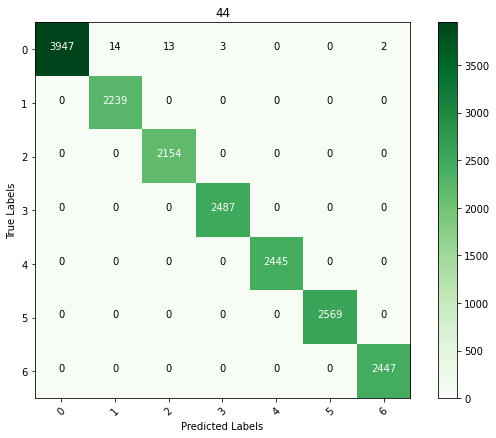

In [71]:
test_model(model, X_test_aug, Y_test_aug)

### Prediction for only one image

In [72]:
def predict_one_image(image_nr):

    predict_only_one = data.iloc[image_nr]
    print("Imid :" ,predict_only_one.image_id)
    print("Real :" ,predict_only_one.cell_type)
    
    new_one = predict_only_one.image_pixel.reshape((1,28,28,3))
    preds=model.predict(new_one)
    pred_probabilty = " % {:.2f}".format(np.amax(preds)*100) 
    max_index_col = np.argmax(preds)
    result=labels.get(max_index_col) + pred_probabilty
    print("Pred :", result)

    sample_data = predict_only_one['image_pixel']
    plt.figure(figsize=(10, 10))
    plt.imshow(sample_data)
    plt.axis("off")
    plt.show() 


Imid : ISIC_0025383
Real : Basal cell carcinoma (bcc)
Pred : Basal cell carcinoma (bcc) % 100.00


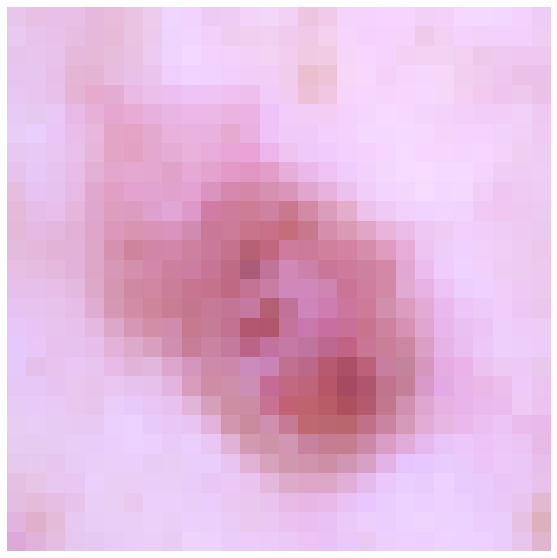

In [76]:
predict_one_image(9372)